<!-- DON'T EDIT THIS CELL! -->
<!-- TYPE SHIFT+ENTER AND GO TO THE NEXT CELL -->

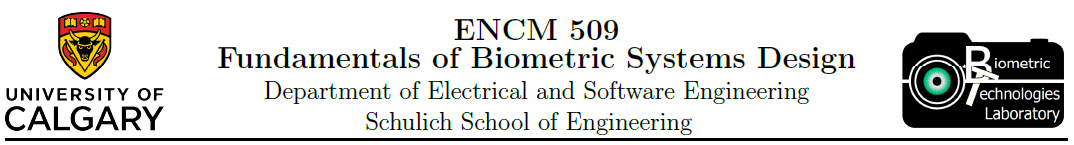

<center>
    <h1>Final Project</h1>
    <h2>Facial Detection</h2>
</center>

Aidan Johnson (30043501)

Cameron Faith (30025734)

March 17th, 2022

In [22]:
import sys
import cv2
import dlib
import skimage
import csv
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import patches

## Introduction

The purpose of this project is to explore three differnet methods of facial detection and evaluate their performance. In this exercise, we will be using nine of our own personal images to complete facial detection. 


Throughout this project, we will go through examples covering Haar cascades, LBP cascade, and finally the performance of HOG+SVM face detection.

### **Common Functions**
Below are a list of the common functions to be used in the project.

In [23]:
"""
Takes in an image path and coverts the image to grayscale.

"""
def convertImageToGrayScale(imPath=None):
    if imPath is None:
        print("No image path was passed!")
        return
    
    image = cv2.imread(imPath)
    grayScaleImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return grayScaleImage

"""
Plots an image in grayscale.

"""
def viewImage(im=None):
    if im is None:
        print("No image was passed!")
        return

    #image = plt.imread(im)
    plt.imshow(im,cmap='gray', vmin=0, vmax=255)
    plt.show()
    return

"""
Performs the Haars cascade facial detection. Different parameters can be passed in to 
change the performance of the haars facial detection algorithm. Returns all the different
faces detected.
"""
def haarsFaceDetect(faceCascade, grayImage, minSize, scaleFactor=1.1, minNeighbors=5):
    faces = faceCascade.detectMultiScale(
                                            grayImage,
                                            scaleFactor=scaleFactor,
                                            minNeighbors=minNeighbors,
                                            minSize=minSize,
                                            flags=cv2.CASCADE_SCALE_IMAGE
                                        )
    return faces

"""
Performs the LBP-based Haars cascade for frontal facial detection using OpenCV. Different parameters can be passed in to change the performance of the haars facial detection algorithm. Returns all the different faces detected. 
"""
def lbpHaarsFaceDetectCV(grayImage, minSize, scaleFactor=1.1, minNeighbors=5):
    # Load LBP cascade classifier training
    lbpFaceCascade = cv2.CascadeClassifier('lbpcascade_frontalface_improved.xml')
    faces = lbpFaceCascade.detectMultiScale(
                                            grayImage,
                                            scaleFactor=scaleFactor,
                                            minNeighbors=minNeighbors,
                                            minSize=minSize,
                                            flags=cv2.CASCADE_SCALE_IMAGE
                                        )
    return faces

"""
Performs the LBP-based Haars cascade for frontal facial detection using Skimage. Different parameters can be passed in to change the performance of the haars facial detection algorithm. Returns all the different faces detected. 

Output Dicts have form {'r': int, 'c': int, 'width': int, 'height': int}, where 'r' represents row position of top left corner of detected window, 'c' - col position, 'width' - width of detected window, 'height' - height of detected window.
"""
def lbpHaarsFaceDetectSki(grayImage, min_size=(30,30), max_size=(1000,1000), scale_factor=1.1, step_ratio=1.1):
    # Load LBP cascade classifier training
    lbpFaceCascade = skimage.feature.Cascade('lbpcascade_frontalface_improved.xml')
    
    faces = lbpFaceCascade.detect_multi_scale(
                                            grayImage,
                                            scale_factor=scale_factor,
                                            step_ratio=step_ratio,
                                            min_size=min_size,
                                            max_size=max_size,
                                        )
    return faces 


"""
Calculates the interzection over union between the ground truth box of an image and the
predicted box for face detection.

"""
def calcIntersectiontionOverUnion(groundTruthBox, predictedBox):
    print(groundTruthBox)
    print(predictedBox)
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(groundTruthBox[0], predictedBox[0])
    yA = max(groundTruthBox[1], predictedBox[1])
    xB = min(groundTruthBox[2], predictedBox[2])
    yB = min(groundTruthBox[3], predictedBox[3])
    print(f"xA = {xA}, yA = {yA}, xB = {xB}, yB = {yB}")

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA+1) * max(0, yB - yA+1)
    print(f"The inter Area is {interArea}")

    # compute the area of both the prediction and ground-truth
    # rectangles
    groundTruthBoxArea = (groundTruthBox[2] - groundTruthBox[0] + 1) * (groundTruthBox[3] - groundTruthBox[1] + 1)
    print(f"Ground truth area is {groundTruthBoxArea}")
    predictedBoxArea = (predictedBox[2] - predictedBox[0] + 1) * (predictedBox[3] - predictedBox[1] + 1)
    print(f"Predicted area is {predictedBoxArea}")
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(groundTruthBoxArea + predictedBoxArea - interArea)
    # return the intersection over union value
    return iou

"""
Plots a rectangle on the given plot based on the coordinates given by x, y, width and height. These values are located in the respective indeces of each item in rectangles. I.e. rectangles = [[x_coord, y_coord, width, height], ...]

"""
def plotRectangle(grayImage, rectangles):

    plt.imshow(grayImage)
    img_desc = plt.gca()
    plt.set_cmap('gray')

    for rect in rectangles:
        img_desc.add_patch(
                    patches.Rectangle(
                        (rect[0], rect[1]),
                        rect[2],
                        rect[3],
                        fill=False,
                        color='r',
                        linewidth=2
                    )
                )
    plt.show()

def testLBPdetect(groundTrueBoundingBox, minImage=1, maxImage=10,  min_size=(30,30), max_size=(1000,1000), scale_factor=1.1, step_ratio=1.4):
    for imageNum in range(minImage, maxImage):
        imagePath = f"Images/personal/{imageNum}.jpg"
        grayImage = convertImageToGrayScale(imagePath)
        faces = lbpHaarsFaceDetectSki(grayImage, min_size=min_size, max_size=max_size, scale_factor=scale_factor, step_ratio=step_ratio)
        # print(faces[0]['r'])
        
        rectangles = []
        for patch in faces:
            rectangles.append([patch['c'], patch['r'], patch['width'], patch['height']])
            if len(groundTrueBoundingBox[imageNum]) == 1:
                predictedBox = [patch['c'], patch['r'], patch['c']+ patch['width'], patch['r']+ patch['height']]
                print(groundTrueBoundingBox[imageNum][0])
                cv2.rectangle(grayImage, (groundTrueBoundingBox[imageNum][0][0], groundTrueBoundingBox[imageNum][0][1]), \
                                        (groundTrueBoundingBox[imageNum][0][2], groundTrueBoundingBox[imageNum][0][3]), (0, 0, 255), 5)
                iouScore = calcIntersectiontionOverUnion(np.array(groundTrueBoundingBox[imageNum][0]), predictedBox)
                print(f"The IoU Score is: {iouScore}")
            else:
                pass
        plotRectangle(grayImage, rectangles)
            


"""
Based off of a specified threshold value this function calculates the total number of 
true positives and false negatives which can be used to create a confusion matrix.
"""
def calcTPandFN(thresholdValue, iouScores):
    numOfTP = 0
    numOfFN = 0
    for iouScore in iouScores:
        if iouScore >= thresholdValue:
            numOfTP += 1
        else:
            numOfFN += 1
    
    return numOfTP, numOfFN

## Initialization
In the setup of our project, we will be initializing the face cascade and ground truth boxes for the 9 images. Since we are using our own personal images for this project, we had to manually place the coordinates for each image. These values are stored in a csv file that is loaded at the start of the program.

In [24]:
cascPath = "haarcascade_frontalface_default.xml"
faceCascade = cv2.CascadeClassifier(cascPath)

groundTrueBoundingBox = [[] for i in range(10)]    #Change this to be based on the number of photos (a variable of length of photos)

with open("updatedGroundTruthBBox.csv") as csvFile:
    groundTruthBoundingBoxes = csv.reader(csvFile, delimiter=',')

    rowCount = 0
    for groundTruthBoundingBox in groundTruthBoundingBoxes:
        if rowCount == 0:
            rowCount += 1
            continue

        imageNumber = int(groundTruthBoundingBox[0])
        coordinates = groundTruthBoundingBox[1:]
        intCoordinates = [int(coordinates[0]), int(coordinates[1]), int(coordinates[2]), int(coordinates[3])]

        groundTrueBoundingBox[imageNumber].append(intCoordinates)
        rowCount += 1

## Procedure

### Haars Cascade

##### With scale factor set to 1.1 (base), minNeighbors set to 5 (base)

In [4]:
for imageNum in range(1,10):
    imagePath = f"Images/personal/{imageNum}.jpg"
    grayImage = convertImageToGrayScale(imagePath)
    #viewImage(grayImage)
    faces = haarsFaceDetect(faceCascade, grayImage, minSize=(30,30), scaleFactor=1.1, minNeighbors=5)
    
    print(faces)
    # Draw a rectangle around the faces
    for (x, y, w, h) in faces:
        cv2.rectangle(grayImage, (x, y), (x+w, y+h), (0, 255, 0), 5)
        predictedBox = [x, y, x+w, y+h]
        iouScores = []
        if len(groundTrueBoundingBox[imageNum]) == 1:
            print(groundTrueBoundingBox[imageNum][0])
            cv2.rectangle(grayImage, (groundTrueBoundingBox[imageNum][0][0], groundTrueBoundingBox[imageNum][0][1]), \
                                    (groundTrueBoundingBox[imageNum][0][2], groundTrueBoundingBox[imageNum][0][3]), (0, 0, 255), 5)
            iouScore = calcIntersectiontionOverUnion(np.array(groundTrueBoundingBox[imageNum][0]), predictedBox)
            print(f"The IoU Score is: {iouScore}")
        else:
            for groundTruthBB in groundTrueBoundingBox[imageNum]:
                cv2.rectangle(grayImage, (groundTruthBB[0], groundTruthBB[1]), \
                    (groundTruthBB[2], groundTruthBB[3]), (0, 0, 255), 5)
                iouScore = calcIntersectiontionOverUnion(np.array(groundTruthBB), predictedBox)
                print(f"The IoU Score is: {iouScore}")

    # Display the resulting picture with the detected bounding box(es)
    cv2.imshow('Face Detection', grayImage)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

[[645 536 140 140]]
[640, 520, 780, 690]
[640 520 780 690]
[645, 536, 785, 676]
xA = 645, yA = 536, xB = 780, yB = 676
The inter Area is 19176
Ground truth area is 24111
Predicted area is 19881
The IoU Score is: 0.7727272727272727
[[ 282  528 1581 1581]]
[585, 600, 1670, 2195]
[ 585  600 1670 2195]
[282, 528, 1863, 2109]
xA = 585, yA = 600, xB = 1670, yB = 2109
The inter Area is 1639860
Ground truth area is 1733256
Predicted area is 2502724
The IoU Score is: 0.6316580127266844
[[2290 1127  638  638]]
[2325, 1025, 2900, 1820]
[2325 1025 2900 1820]
[2290, 1127, 2928, 1765]
xA = 2325, yA = 1127, xB = 2900, yB = 1765
The inter Area is 368064
Ground truth area is 458496
Predicted area is 408321
The IoU Score is: 0.737968493422596
[[1110 1532  234  234]
 [ 767 1560  219  219]]
[ 770 1550  970 1810]
[1110, 1532, 1344, 1766]
xA = 1110, yA = 1550, xB = 970, yB = 1766
The inter Area is 0
Ground truth area is 52461
Predicted area is 55225
The IoU Score is: 0.0
[1130 1500 1330 1780]
[1110, 1532, 1

##### With Scale factor set to 2, minNeighbors set to 5 (base) 

In [5]:
for imageNum in range(1,10):
    imagePath = f"Images/personal/{imageNum}.jpg"
    grayImage = convertImageToGrayScale(imagePath)
    #viewImage(grayImage)
    faces = haarsFaceDetect(faceCascade, grayImage, minSize=(30,30), scaleFactor=2, minNeighbors=5)
    
    print(faces)
    # Draw a rectangle around the faces
    for (x, y, w, h) in faces:
        cv2.rectangle(grayImage, (x, y), (x+w, y+h), (0, 255, 0), 5)
        predictedBox = [x, y, x+w, y+h]
        iouScores = []
        if len(groundTrueBoundingBox[imageNum]) == 1:
            print(groundTrueBoundingBox[imageNum][0])
            cv2.rectangle(grayImage, (groundTrueBoundingBox[imageNum][0][0], groundTrueBoundingBox[imageNum][0][1]), \
                                    (groundTrueBoundingBox[imageNum][0][2], groundTrueBoundingBox[imageNum][0][3]), (0, 0, 255), 5)
            iouScore = calcIntersectiontionOverUnion(np.array(groundTrueBoundingBox[imageNum][0]), predictedBox)
            print(f"The IoU Score is: {iouScore}")
        else:
            for groundTruthBB in groundTrueBoundingBox[imageNum]:
                cv2.rectangle(grayImage, (groundTruthBB[0], groundTruthBB[1]), \
                    (groundTruthBB[2], groundTruthBB[3]), (0, 0, 255), 5)
                iouScore = calcIntersectiontionOverUnion(np.array(groundTruthBB), predictedBox)
                print(f"The IoU Score is: {iouScore}")

    # Display the resulting picture with the detected bounding box(es)
    cv2.imshow('Face Detection', grayImage)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

()
[[ 283  544 1536 1536]]
[585, 600, 1670, 2195]
[ 585  600 1670 2195]
[283, 544, 1819, 2080]
xA = 585, yA = 600, xB = 1670, yB = 2080
The inter Area is 1608366
Ground truth area is 1733256
Predicted area is 2362369
The IoU Score is: 0.6466419460136641
()
[[ 779 1572  192  192]
 [1129 1552  192  192]]
[ 770 1550  970 1810]
[779, 1572, 971, 1764]
xA = 779, yA = 1572, xB = 970, yB = 1764
The inter Area is 37056
Ground truth area is 52461
Predicted area is 37249
The IoU Score is: 0.7037641964523114
[1130 1500 1330 1780]
[779, 1572, 971, 1764]
xA = 1130, yA = 1572, xB = 971, yB = 1764
The inter Area is 0
Ground truth area is 56481
Predicted area is 37249
The IoU Score is: 0.0
[ 770 1550  970 1810]
[1129, 1552, 1321, 1744]
xA = 1129, yA = 1552, xB = 970, yB = 1744
The inter Area is 0
Ground truth area is 52461
Predicted area is 37249
The IoU Score is: 0.0
[1130 1500 1330 1780]
[1129, 1552, 1321, 1744]
xA = 1130, yA = 1552, xB = 1321, yB = 1744
The inter Area is 37056
Ground truth area is 5

##### With Scale factor set to 1.1 (base), minNeighbors set to 3

In [6]:
for imageNum in range(1,10):
    imagePath = f"Images/personal/{imageNum}.jpg"
    grayImage = convertImageToGrayScale(imagePath)
    #viewImage(grayImage)
    faces = haarsFaceDetect(faceCascade, grayImage, minSize=(30,30), scaleFactor=1.1, minNeighbors=3)
    
    print(faces)
    # Draw a rectangle around the faces
    for (x, y, w, h) in faces:
        cv2.rectangle(grayImage, (x, y), (x+w, y+h), (0, 255, 0), 5)
        predictedBox = [x, y, x+w, y+h]
        iouScores = []
        if len(groundTrueBoundingBox[imageNum]) == 1:
            print(groundTrueBoundingBox[imageNum][0])
            cv2.rectangle(grayImage, (groundTrueBoundingBox[imageNum][0][0], groundTrueBoundingBox[imageNum][0][1]), \
                                    (groundTrueBoundingBox[imageNum][0][2], groundTrueBoundingBox[imageNum][0][3]), (0, 0, 255), 5)
            iouScore = calcIntersectiontionOverUnion(np.array(groundTrueBoundingBox[imageNum][0]), predictedBox)
            print(f"The IoU Score is: {iouScore}")
        else:
            for groundTruthBB in groundTrueBoundingBox[imageNum]:
                cv2.rectangle(grayImage, (groundTruthBB[0], groundTruthBB[1]), \
                    (groundTruthBB[2], groundTruthBB[3]), (0, 0, 255), 5)
                iouScore = calcIntersectiontionOverUnion(np.array(groundTruthBB), predictedBox)
                print(f"The IoU Score is: {iouScore}")

    # Display the resulting picture with the detected bounding box(es)
    cv2.imshow('Face Detection', grayImage)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

[[645 536 140 140]
 [897 838  72  72]]
[640, 520, 780, 690]
[640 520 780 690]
[645, 536, 785, 676]
xA = 645, yA = 536, xB = 780, yB = 676
The inter Area is 19176
Ground truth area is 24111
Predicted area is 19881
The IoU Score is: 0.7727272727272727
[640, 520, 780, 690]
[640 520 780 690]
[897, 838, 969, 910]
xA = 897, yA = 838, xB = 780, yB = 690
The inter Area is 0
Ground truth area is 24111
Predicted area is 5329
The IoU Score is: 0.0
[[ 282  528 1581 1581]]
[585, 600, 1670, 2195]
[ 585  600 1670 2195]
[282, 528, 1863, 2109]
xA = 585, yA = 600, xB = 1670, yB = 2109
The inter Area is 1639860
Ground truth area is 1733256
Predicted area is 2502724
The IoU Score is: 0.6316580127266844
[[2290 1127  638  638]
 [2084 1230   68   68]
 [1766  877   98   98]
 [2713 2428  507  507]]
[2325, 1025, 2900, 1820]
[2325 1025 2900 1820]
[2290, 1127, 2928, 1765]
xA = 2325, yA = 1127, xB = 2900, yB = 1765
The inter Area is 368064
Ground truth area is 458496
Predicted area is 408321
The IoU Score is: 0.73

### LBP
Investigating various parameters for the LBP-based Haar cascades. We will investigate 3 different iterations of scale_ratio and step_ratio and then 2 iterations of min_size and max_size.

**Varying scale_ratio all other parameters constant.**

[640, 520, 780, 690]
[640 520 780 690]
[669, 574, 763, 668]
xA = 669, yA = 574, xB = 763, yB = 668
The inter Area is 9025
Ground truth area is 24111
Predicted area is 9025
The IoU Score is: 0.3743104806934594


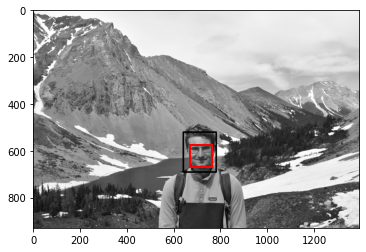

[585, 600, 1670, 2195]
[ 585  600 1670 2195]
[632, 992, 1493, 1853]
xA = 632, yA = 992, xB = 1493, yB = 1853
The inter Area is 743044
Ground truth area is 1733256
Predicted area is 743044
The IoU Score is: 0.4286983573113262


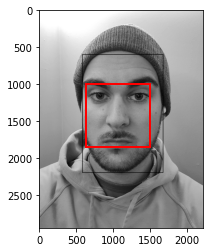

[2325, 1025, 2900, 1820]
[2325 1025 2900 1820]
[2417, 1300, 2814, 1697]
xA = 2417, yA = 1300, xB = 2814, yB = 1697
The inter Area is 158404
Ground truth area is 458496
Predicted area is 158404
The IoU Score is: 0.3454861111111111


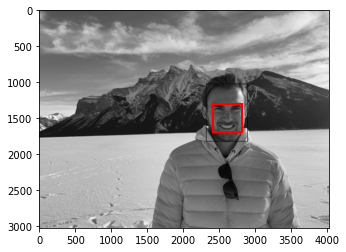

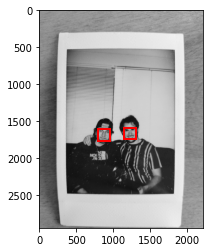

[400, 400, 610, 680]
[400 400 610 680]
[437, 489, 593, 645]
xA = 437, yA = 489, xB = 593, yB = 645
The inter Area is 24649
Ground truth area is 59291
Predicted area is 24649
The IoU Score is: 0.4157292000472247


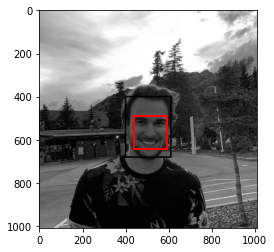

[1100, 440, 1220, 600]
[1100  440 1220  600]
[1127, 505, 1208, 586]
xA = 1127, yA = 505, xB = 1208, yB = 586
The inter Area is 6724
Ground truth area is 19481
Predicted area is 6724
The IoU Score is: 0.34515681946511984


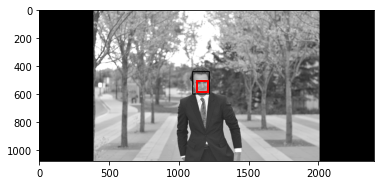

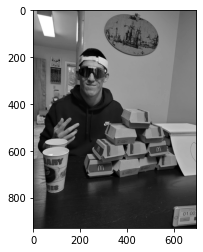

[330, 320, 410, 400]
[330 320 410 400]
[358, 336, 405, 383]
xA = 358, yA = 336, xB = 405, yB = 383
The inter Area is 2304
Ground truth area is 6561
Predicted area is 2304
The IoU Score is: 0.3511659807956104


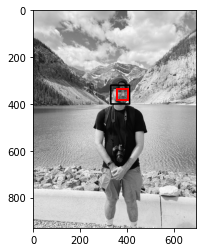

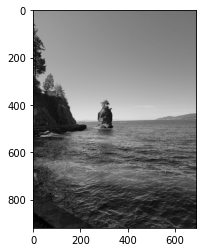

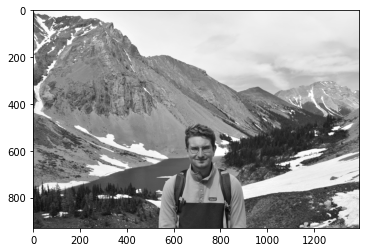

[585, 600, 1670, 2195]
[ 585  600 1670 2195]
[673, 1052, 1409, 1788]
xA = 673, yA = 1052, xB = 1409, yB = 1788
The inter Area is 543169
Ground truth area is 1733256
Predicted area is 543169
The IoU Score is: 0.31338071237024423


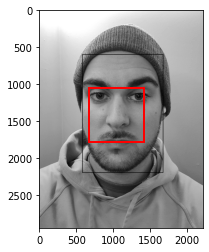

KeyboardInterrupt: 

In [26]:
testLBPdetect(groundTrueBoundingBox, scale_factor=1.1)
testLBPdetect(groundTrueBoundingBox, scale_factor=1.5)
testLBPdetect(groundTrueBoundingBox, scale_factor=2)

**Varying step_ratio all other parameters constant.**

**Varying min_size all other parameters constant.**


**Varying max_size all other parameters constant.**


### Hog + SVM

# Conclusion
In conclusion, this lab illustrates concepts of the Bayesian network and in this lab we were able to explore its various properties including Bayes rule, joint probabilities, and finally the importance of a complete CPT. Throughout the lab, we challenged the theory learned in class by completing the exercise probability calculations manually first and then comparing them with the probabilities calculated by the PyAgrum library. 

As seen from examples 1 and 2, PyAgrum's calculation's aligned with the expected values calculated by hand and shows the library's usefulness in machine reasoning to accurately calculate different probabilities. In example, 3 and 4, we evaluated the importance of a complete CPT and why it is necessary to define all entries in the network.